In [43]:
import ta.momentum
import ta.trend
import ta.volatility
import yfinance as yf
import ta
import numpy as np
from sklearn.preprocessing import StandardScaler
import gymnasium as gym
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from gymnasium import spaces


class DataLoader:
  def __init__(self, pair="BTC-USD", start='2020-01-01', end='2023-01-01', freq='1d'):
    self.pair = pair
    self.start = start
    self.end = end
    self.freq = freq
    
    self.yfLoad()
    
    self.scaler = StandardScaler()
    self.scaler.fit(self.data[:, 1:])

  def __len__(self):
      return len(self.data)
      
  def __getitem__(self, idx, col_idx=None):
      if col_idx is None:
        return self.data[idx]
      elif col_idx < len(list(self.data.columns)):
        return self.data[idx][col_idx]
      else:
        raise IndexError
    
  def yfLoad(self):
    df = yf.download([self.pair], start=self.start, end=self.end, interval=self.freq)
    

    df['next_day_reward'] = df['Adj Close'].pct_change().shift(-1)
    # df['price'] = df['Adj Close']
    df['reward_day'] = df['Adj Close'].pct_change(1)
    
    rsi = ta.momentum.RSIIndicator(df['reward_day'], window=14)
    
    # bb = ta.volatility.BollingerBands(df['reward_day'], window=20, window_dev=2)

    macd = ta.trend.MACD(df['reward_day'], window_slow=26, window_fast=12, window_sign=9)

    df['RSI'] = rsi.rsi()
    df['MACD'] = macd.macd()
    df['MACD_Signal'] = macd.macd_signal()
    df['Volume_day_pct_change'] = df['Volume'].pct_change(1)


    # Bollinger Bands
    bollinger_lback = 20
    df["bollinger"] = df["reward_day"].ewm(bollinger_lback).mean()
    df["low_bollinger"] = df["bollinger"] - 2 * df["reward_day"].rolling(bollinger_lback).std()
    df["high_bollinger"] = df["bollinger"] + 2 * df["reward_day"].rolling(bollinger_lback).std()

    # Filtering
    for c in df.columns:
      df[c] = df[c].interpolate('linear', limit_direction='both')
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)

    self.frame = df
    
    # drop yfinance fetched values
    self.data = np.array(df.iloc[:, 6:])

    return self.data
  
  def scaleData(self):
    self.scaled_data = self.scaler.fit_transform(self.data[:, 1:])
    return self.scaled_data
  

In [44]:
class StockTradingEnv(gym.Env):
    def __init__(self, data, initial_budget=10000, budget_threshold = 0.1, investment_fraction = 0.1, tx_fee = 0.01):
        super(StockTradingEnv, self).__init__()
        
        self.data = data
  
        self.budget_threshold = budget_threshold
        self.initial_budget = initial_budget  
        self.budget_remaining = self.initial_budget
        self.budget = self.initial_budget
        self.investment_fraction = investment_fraction
        self.tx_fee = tx_fee
        
        self.done_idx = len(self.data) - 1
        self.current_step = 0
        self.invested = 0
        self.previous_action = 0  # 0 = HOLD
        self.capital_history = []
    
  
        self.action_space = spaces.Discrete(3, start=0)  # Actions: Buy, Hold, Sell
        self.observation_space = spaces.Box(
            low=0, high=1, 
            shape=(11,),  # Updated to include additional DCA metrics
            dtype=np.float32
        )

    def check_done(self):
        if self.current_step >= self.done_idx or self.budget <= self.initial_budget * self.budget_threshold:
            return True
        
        return False

    def calculate_reward(self, action, price):
        penalty = 0
        investment = self.budget_remaining * self.investment_fraction
        
        if action == 1:
            if self.budget_remaining > self.initial_budget * self.budget_threshold:
                self.budget_remaining -= investment
                self.invested += investment / price
        elif action == -1 and self.invested > 0: # Sell action
            self.budget_remaining += (self.invested * price) * (1 - self.tx_fee)
            self.invested = 0
        elif action == 0: # Hold action
            if self.previous_action == 0: # Penalty for holding
                penalty += 0.1
        
        self.budget = self.budget_remaining + self.invested * price
        reward = 100 * self.next_return * action - np.abs(action - self.previous_action) * self.tx_fee
        
        if reward < 0:
            reward *= 10
            
        reward -= penalty
        
        return reward
 
    def get_state(self, idx, price):
        state = self.data[idx][1:]
        state = self.data.scaler.transform(state.reshape(1, -1))

        state = np.concatenate([state, [[self.budget/self.initial_budget,
                                        self.budget_remaining/self.budget,
                                        self.invested * price/self.initial_budget,
                                        self.previous_action]]], axis=-1)
        
        next_ret = self.data[idx][0]
        
        # print
        return next_ret, state

    def reset(self):
        self.current_step = 0
        self.previous_action = 0
        self.invested = 0
     
        self.budget_remaining = self.initial_budget
        self.budget = self.initial_budget
        self.capital_history = []
        self.current_price = self.data.frame.iloc[self.current_step, :]['Adj Close']
        self.next_return, self.current_state = self.get_state(self.current_step, self.current_price)
     
        return self.current_state 

    def step(self, action):
        self.current_price = self.data.frame.iloc[self.current_step, :]['Adj Close']
        self.current_reward = self.calculate_reward(action, self.current_price)
        self.previous_action = action
        self.current_step += 1
        self.next_return, self.current_state = self.get_state(self.current_step, self.current_price)
        self.done = self.check_done()
        
        if self.done:
            capital_increase = self.capital_history[-1] / self.capital_history[0]
            self.current_reward += (capital_increase - 1) * 10
            
            if self.current_step < self.done_idx:
                if capital_increase < 0:
                    self.current_reward += -10 * (1 - self.current_step/self.done_idx)
                
        self.capital_history.append(self.budget)

        return self.current_state, self.current_reward, self.done, {}

# 3. Define the Q-Learning Agent
class TradingAgent(nn.Module):
    def __init__(self):
        super(TradingAgent, self).__init__()
        self.fc1 = nn.Linear(12, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 3)  # 3 Actions: Buy, Hold, Sell

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


def train_agent(agent, env, num_episodes, epsilon_start=1.0, epsilon_end=0.1, epsilon_decay=0.995):
    optimizer = optim.Adam(agent.parameters(), lr=0.01)
    criterion = nn.MSELoss()    
    epsilon = epsilon_start
    gamma = 0.99
    act_dict = {0:-1, 1:1, 2:0}


    for episode in range(num_episodes):
        state = env.reset()
        state = torch.FloatTensor(state)
        done = False
        total_reward = 0  # Reset total reward for each episode

        while not done:
            if np.random.uniform(0, 1) < epsilon:  # Îµ-greedy: Explore
                action = env.action_space.sample()
            else:  # Exploit
                with torch.no_grad():
                    q_values = agent(state)
        
                action = torch.argmax(q_values).item()

            
            next_state, reward, done, _ = env.step(act_dict[action])
            next_state = torch.FloatTensor(next_state)

            q_value = agent(state)[0, action]
            
            with torch.no_grad():
                next_q_value = torch.max(agent(next_state))
                target = reward + gamma * next_q_value  # Standard Q-learning target

            loss = criterion(q_value, target)  # Standard MSE Loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            state = next_state
            total_reward += reward  # Accumulate total reward for the episode

        print(f"Episode {episode + 1}/{num_episodes}, Total Reward: {total_reward}")

        if epsilon > epsilon_end:
            epsilon *= epsilon_decay


agent = TradingAgent()
data = DataLoader()
env = StockTradingEnv(data)
print("Training the agent...")
train_agent(agent, env, num_episodes=100)

[*********************100%***********************]  1 of 1 completed

Training the agent...
Episode 1/100, Total Reward: -8272.937242879476
Episode 2/100, Total Reward: -8048.84929904223
Episode 3/100, Total Reward: -8324.416358362885
Episode 4/100, Total Reward: -7985.494796850631
Episode 5/100, Total Reward: -8114.914459691576
Episode 6/100, Total Reward: -9106.934298498223
Episode 7/100, Total Reward: -7941.542314906268
Episode 8/100, Total Reward: -8718.191761584767
Episode 9/100, Total Reward: -8102.975327374845
Episode 10/100, Total Reward: -8293.310215838024
Episode 11/100, Total Reward: -8629.68796015843
Episode 12/100, Total Reward: -7345.241436451202
Episode 13/100, Total Reward: -7828.44013251962
Episode 14/100, Total Reward: -8861.776175673678
Episode 15/100, Total Reward: -7890.217344169583
Episode 16/100, Total Reward: -7965.043781545757
Episode 17/100, Total Reward: -7644.462813977208
Episode 18/100, Total Reward: -6899.672076840636
Episode 19/100, Total Reward: -7704.323404794565
Episode 20/100, Total Reward: -7359.37695525125
Episode 21/

[*********************100%***********************]  1 of 1 completed

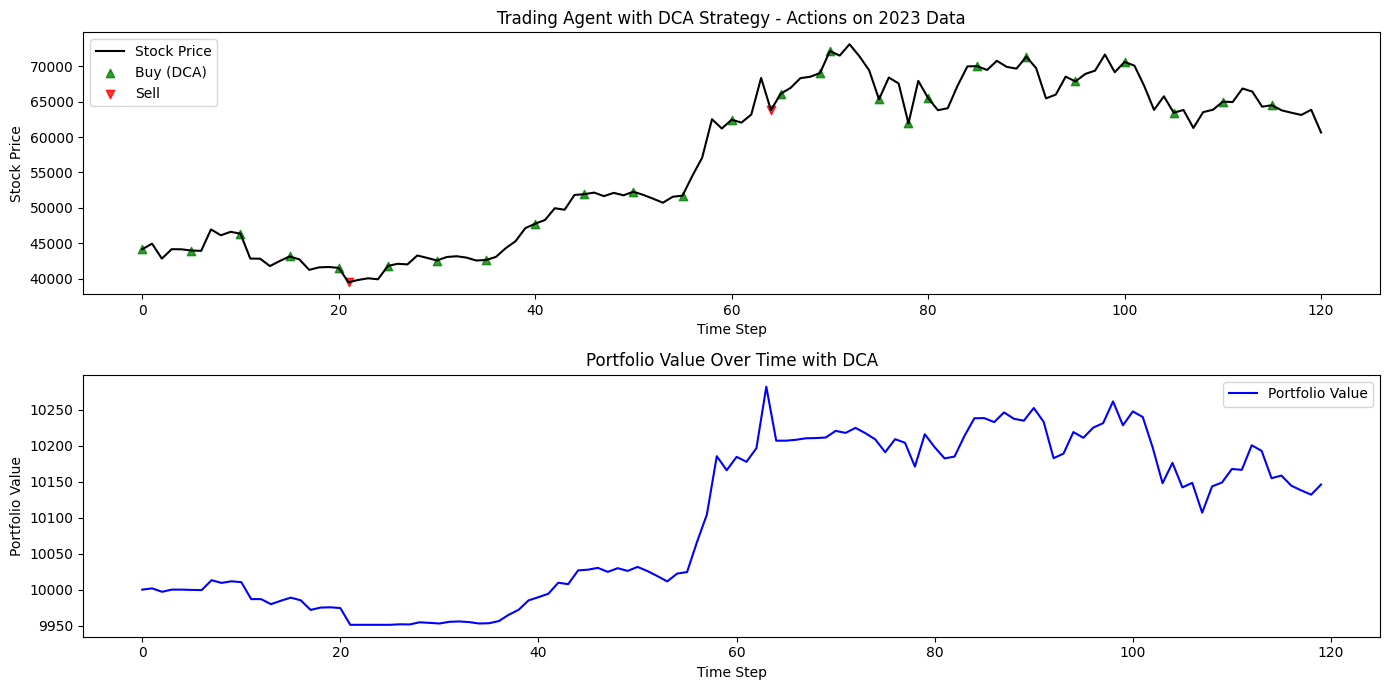

In [45]:
import matplotlib.pyplot as plt

def test_agent_dca(agent, env, data_loader, initial_balance=10000, dca_amount=100, buy_interval=5):
    state = env.reset()
    state = torch.FloatTensor(state)
    done = False
    prices = data_loader.frame['Adj Close'].tolist()
    actions = []
    
    cash_balance = initial_balance
    holdings = 0
    portfolio_values = []
    step = 0
    act_dict = {0:-1, 1:1, 2:0}

    for price in prices:
        action = 0
        
        if step % buy_interval == 0 and cash_balance >= dca_amount:
            num_shares = dca_amount / price
            holdings += num_shares
            cash_balance -= dca_amount
            actions.append(1)  # Log "DCA buy"
        else:
            with torch.no_grad():
                q_values = agent(state)
                action = torch.argmax(q_values).item()

            if action == 1 and cash_balance >= dca_amount:  # Buy
                num_shares = dca_amount / price
                holdings += num_shares
                cash_balance -= dca_amount
                actions.append(1)  # Log "buy"
            elif action == 0 and holdings > 0:  # Sell
                cash_balance += holdings * price
                holdings = 0
                actions.append(0)  # Log "sell"
            else:
                actions.append(2)  # Log "hold"

        portfolio_value = cash_balance + holdings * price
        portfolio_values.append(portfolio_value)

        next_state, reward, done, _ = env.step(act_dict[action])
        state = torch.FloatTensor(next_state)
        step += 1
        if done:
            break

    return prices, actions, portfolio_values

def plot_dca_results(prices, actions, portfolio_values):
    plt.figure(figsize=(14, 7))
    plt.subplot(2, 1, 1)
    plt.plot(prices, label="Stock Price", color="black")
    buy_indices = [i for i, a in enumerate(actions) if a == 1]
    sell_indices = [i for i, a in enumerate(actions) if a == 0]

    plt.scatter(buy_indices, [prices[i] for i in buy_indices], color="green", label="Buy (DCA)", marker="^", alpha=0.8)
    plt.scatter(sell_indices, [prices[i] for i in sell_indices], color="red", label="Sell", marker="v", alpha=0.8)
    plt.title("Trading Agent with DCA Strategy - Actions on 2023 Data")
    plt.xlabel("Time Step")
    plt.ylabel("Stock Price")
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(portfolio_values, label="Portfolio Value", color="blue")
    plt.title("Portfolio Value Over Time with DCA")
    plt.xlabel("Time Step")
    plt.ylabel("Portfolio Value")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Load 2023 data
data = DataLoader(start='2024-01-01', end='2024-05-01')
env = StockTradingEnv(data)

# Test the trained agent with DCA and plot the results
prices, actions, portfolio_values = test_agent_dca(agent, env, data)
plot_dca_results(prices, actions, portfolio_values)